In [160]:
from scipy.io import loadmat
from sklearn.model_selection import train_test_split 
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

import pandas as pd
import requests
from io import StringIO

import torch
from torch.utils.data import DataLoader




In [161]:
# DEFINE FUNCTIONS 

# Generate output values (ystar) based on the past input (upast) and past output (ypast) values
def f(upast, ypast):
    ukm = upast[-nb:]  # Take the last nb elements of upast
    ykm = ypast[-na:]  # Take the last na elements of ypast
    ystar = (0.8 - 0.5 * np.exp(-ykm[-1] ** 2)) * ykm[-1] - (0.3 + 0.9 * np.exp(-ykm[-1] ** 2)) * ykm[-2] \
            + ukm[-1] + 0.2 * ukm[-2] + 0.1 * ukm[-1] * ukm[-2]
    return ystar + np.random.normal(scale=0.01)



# Simulate NARX with input values (ulist), model function (f), autoregressive (na) & exogenous inputs (na)
def use_NARX_model_in_simulation(ulist, f, na, nb): 

    upast = np.zeros(nb) 
    ypast = np.zeros(na)

    ylist = []
    for unow in ulist:
        # compute the current output value y given by f
        ynow = f(upast, ypast)

        # update past arrays
        upast = np.roll(upast, -1)
        upast[-1] = unow[-1]  # Take the last element of unow
        ypast = np.roll(ypast, -1)
        ypast[-1] = ynow

        # save result
        ylist.append(ynow)
    return np.array(ylist)

    
np.random.seed(42)
na, nb = 2, 2 # autoregressive (na) & exogenous (nb) will affect the number of columns
# na = no. of past output values (y) 
# nb = no. of past input values (u)


# Create the training data by combining the past input and output values using na & nb as a criteria.

def make_training_data(ulist,ylist,na,nb):
    Xdata = []
    Ydata = []
    #for loop over the data:
    for k in range(max(na,nb),len(ulist)): #skip the initial indices that don't have enough past input and output values to form a complete feature vector.
        Xdata.append(np.concatenate([ulist[k-nb:k],ylist[k-na:k]]))  # constructs a feature vector Xdata by concatenating the past nb input values and past na output values. 
        Ydata.append(ylist[k]) # corresponding current output value ylist[k] is appended to the target values list Ydata.
        
    return np.array(Xdata), np.array(Ydata)

In [162]:
# # Load prediction file data

# import pandas as pd

# # Load test prediction data using csv
# file_path = r'C:\Users\ongji\OneDrive\Documents\TUe\Quartile 4\5SC28\Design Assignment\gym-unbalanced-disk-master\disc-benchmark-files\test-prediction-submission-file.csv'
# df = pd.read_csv(file_path)

# u15 = df["# u[k-15]"].to_numpy()
# u14 = df[" u[k-14]"].to_numpy()
# u13 = df[" u[k-13]"].to_numpy()
# u12 = df[" u[k-12]"].to_numpy()
# u11 = df[" u[k-11]"].to_numpy()
# u10 = df[" u[k-10]"].to_numpy()
# u9 = df[" u[k-9]"].to_numpy()
# u8 = df[" u[k-8]"].to_numpy()
# u7 = df[" u[k-7]"].to_numpy()
# u6 = df[" u[k-6]"].to_numpy()
# u5 = df[" u[k-5]"].to_numpy()
# u4 = df[" u[k-4]"].to_numpy()
# u3 = df[" u[k-3]"].to_numpy()
# u2 = df[" u[k-2]"].to_numpy()
# u1 = df[" u[k-1]"].to_numpy()

# y15 = df["y[k-15]"].to_numpy()
# y14 = df[" y[k-14]"].to_numpy()
# y13 = df[" y[k-13]"].to_numpy()
# y12 = df[" y[k-12]"].to_numpy()
# y11 = df[" y[k-11]"].to_numpy()
# y10 = df[" y[k-10]"].to_numpy()
# y9 = df[" y[k-9]"].to_numpy()
# y8 = df[" y[k-8]"].to_numpy()
# y7 = df[" y[k-7]"].to_numpy()
# y6 = df[" y[k-6]"].to_numpy()
# y5 = df[" y[k-5]"].to_numpy()
# y4 = df[" y[k-4]"].to_numpy()
# y3 = df[" y[k-3]"].to_numpy()
# y2 = df[" y[k-2]"].to_numpy()
# y1 = df[" y[k-1]"].to_numpy()


# u_columns = [u15, u14, u13, u12, u11, u10, u9, u8, u7, u6, u5, u4, u3, u2, u1]
# u_values = np.concatenate(u_columns)
# y_columns = [y15, y14, y13, y12, y11, y10, y9, y8, y7, y6, y5, y4, y3, y2, y1]
# y_values = np.concatenate(y_columns)


# Xtest, Ytest = make_training_data(u_values, y_values, na=na, nb=nb)

# # Print the shape and values of the resulting array
# print('u_values', u_values.shape)
# print('u_values', u_values)
# print('y_values', y_values.shape)
# print('y_values', y_values)
# print('Xtest', Xtest.shape)
# print('Ytest', Ytest.shape)



In [163]:
# # Load simulation file data 

# # Load test prediction data using csv
# file_path = r'C:\Users\ongji\OneDrive\Documents\TUe\Quartile 4\5SC28\Design Assignment\gym-unbalanced-disk-master\disc-benchmark-files\test-simulation-submission-file.csv'
# df = pd.read_csv(file_path)
# XdataOut = df["# u"].to_numpy()
# YdataOut = df[" th"].to_numpy()

# YdataOut = YdataOut[:50]
# print(XdataOut.shape, YdataOut.shape)
# print(YdataOut)

In [164]:
# Splitting of data


#Load training data using csv
file_path = r'C:\Users\ongji\OneDrive\Documents\TUe\Quartile 4\5SC28\Design Assignment\gym-unbalanced-disk-master\disc-benchmark-files\training-data.csv'
df = pd.read_csv(file_path)
XdataOut = df["# u"].to_numpy()
YdataOut = df[" th"].to_numpy()


# Create Training and Validation sets based on na & nb values 
Xdata, Ydata = make_training_data(XdataOut, YdataOut, na=na, nb=nb)


# Distribution of data (ver 1.0)
#Xtrain, Xval, Ytrain, Yval = train_test_split(Xdata, Ydata)

#Distribution of data (ver 2.0)
Xtrain_val, Xtest, Ytrain_val, Ytest = train_test_split(Xdata, Ydata, test_size=0.2, random_state=42)
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain_val, Ytrain_val, test_size=0.25, random_state=42)
print(Xtrain.shape, Xval.shape, Xtest.shape)
print(Ytrain.shape, Yval.shape, Ytest.shape)


# Arrays are further processed by squeezing them to remove any single-dimensional entries. eg. (300,1) to (300,)
Xtrain = np.squeeze(Xtrain)
Xval = np.squeeze(Xval)
Xtest = np.squeeze(Xtest)
Ytrain = np.squeeze(Ytrain)
Yval = np.squeeze(Yval)
Ytest = np.squeeze(Ytest)


# Random sampling on the NEW Training and Validation sets (THIS SUBSET SIZES ARE IMPORTANT)
size_train = Xtrain.shape[0]
size_val = Xval.shape[0]
size_test = Xtest.shape[0]

subset_size_train = 500
subset_size_val = 100
subset_size_test = 100

random_select_train = np.random.choice(size_train, size=subset_size_train)
random_select_val = np.random.choice(size_val, size=subset_size_val)
random_select_test = np.random.choice(size_test, size=subset_size_test)

Xtrain = Xtrain[random_select_train]
Xval = Xval[random_select_val]
Xtest = Xtest[random_select_test]
Ytrain = Ytrain[random_select_train]
Yval = Yval[random_select_val]
Ytest = Ytest[random_select_test]


# Print to check 
#print('Xdata: ', Xdata.shape)
# print('Ydata: ', Ydata.shape)
print('X Training data: ',Xtrain.shape)
print('X Validation data: ',Xval.shape)
print ('X test data: ', Xtest.shape)
print('Y Training data: ', Ytrain.shape)
print('Y Validation data: ', Yval.shape)
print('Y Test data: ', Ytest.shape)
#print('All of X Training data points:', Xtrain)
#print ('X validation points: ', Xval)


(47998, 4) (16000, 4) (16000, 4)
(47998,) (16000,) (16000,)
X Training data:  (500, 4)
X Validation data:  (100, 4)
X test data:  (100, 4)
Y Training data:  (500,)
Y Validation data:  (100,)
Y Test data:  (100,)


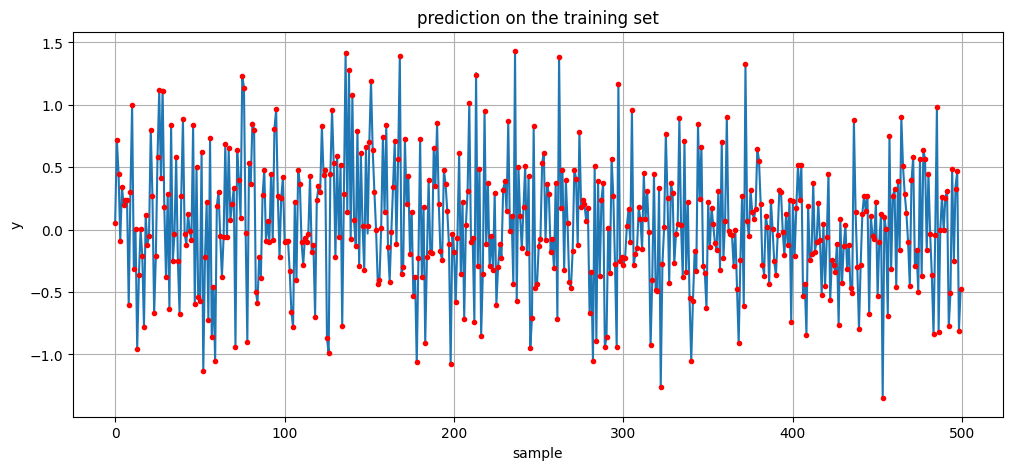

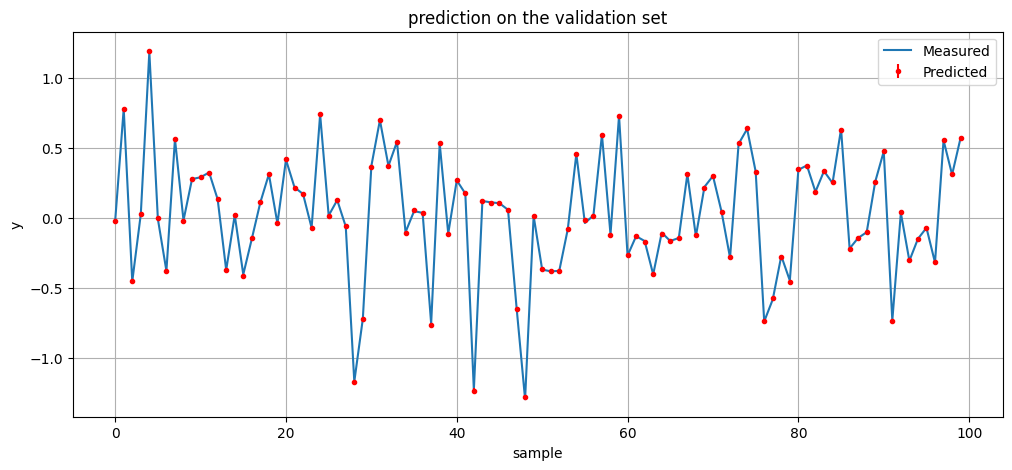

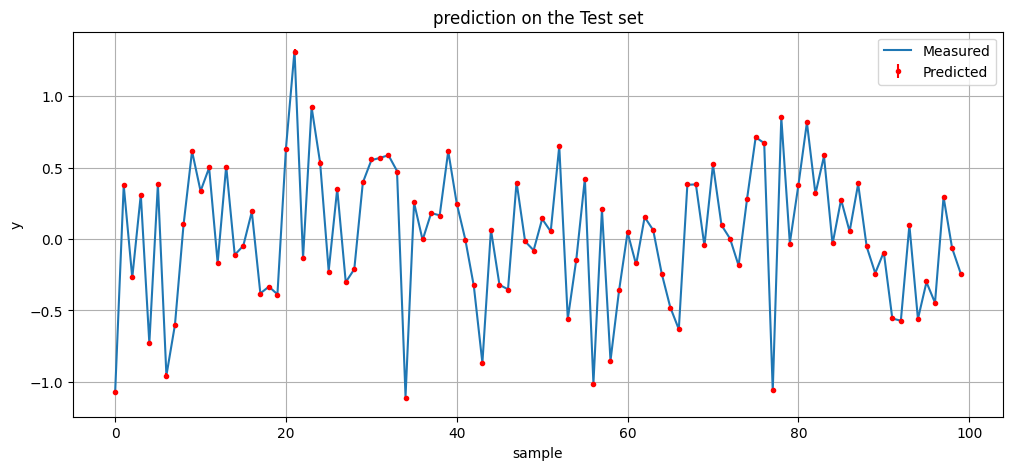

In [165]:
# Fit a Gaussian process regression model with different kernel functions, 
# Make predictions on the training and validation sets, visualize the predictions,
# Evaluate the model's performance on the validation set. 


#Import libraries 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel,Matern, RationalQuadratic, ExpSineSquared, DotProduct
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score, KFold

# TRYING OUT DIFFERENT KERNEL(S)
#ker = DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-5, 1e5)) + ExpSineSquared(length_scale=1.0, periodicity=1.0)
#ker = DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-5, 1e5))
#ker = ExpSineSquared(length_scale=1.0, periodicity=1.0)
#ker = Matern(length_scale= 0.1, nu = 2.5) + WhiteKernel(noise_level=0.01) + RationalQuadratic(length_scale=0.1)
#ker = Matern(length_scale= 0.1, nu = 2.5) + WhiteKernel(noise_level=0.01) +  RBF(length_scale=0.1) + RationalQuadratic(length_scale=0.1)
#ker = Matern(length_scale= 0.1, nu = 2.5) + WhiteKernel(noise_level=0.01) #a=)
#ker = RBF(length_scale=0.1) + RationalQuadratic(length_scale=1.0, alpha=0.1) + WhiteKernel(noise_level=0.01)
#ker = RationalQuadratic(length_scale=0.1) + RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)
#ker = RationalQuadratic(length_scale=0.1) + WhiteKernel(noise_level=0.01) #a=)
#ker = Matern(length_scale= 0.1, nu = 2.5) + WhiteKernel(noise_level=0.01) + RBF(length_scale=0.1)
#ker = ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) * RBF(1.0, length_scale_bounds=(1e-5, 1e5))
ker = RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01, noise_level_bounds=(1e-5, 1e5))
#ker = RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)



# Gaussian process regression
reg = GaussianProcessRegressor(ker, n_restarts_optimizer=10)
#reg = GaussianProcessRegressor(ker, n_restarts_optimizer=10, alpha = 0.01) #Regularization



# Train the GP regression model by fitting the model to the training data. 
reg.fit(Xtrain,Ytrain) #a)

# Make prediction with the TRAINED (after fitting) model and returns predicted target values Yval_pred & Ytrain_pred
Ytrain_pred, Ytrain_pred_std = reg.predict(Xtrain,return_std=True)
Yval_pred, Yval_pred_std = reg.predict(Xval,return_std=True) # std = standard dev or uncertainty of predictions
Ytest_pred, Ytest_pred_std = reg.predict(Xtest,return_std=True)


# RESIDUAL plots of training set 
plt.figure(figsize=(12,5)) 
plt.title('prediction on the training set')
plt.grid(); plt.xlabel('sample'); plt.ylabel('y')
plt.plot(Ytrain, label='Measured') # plots the measured values of the training set
plt.errorbar(np.arange(len(Xtrain)), (Ytrain_pred), yerr=2*Ytrain_pred_std,fmt='.r', label='Predicted') 
plt.show() 



# Residual plots of validation set 
plt.figure(figsize=(12,5)) 
plt.title('prediction on the validation set')
plt.grid(); plt.xlabel('sample'); plt.ylabel('y')
plt.plot(Yval, label='Measured') 
plt.errorbar(np.arange(len(Xval)), (Yval_pred), yerr=2*Yval_pred_std,fmt='.r', label='Predicted') 
plt.legend()
plt.show()


# Residual plots of Test set 
plt.figure(figsize=(12,5)) 
plt.title('prediction on the Test set')
plt.grid(); plt.xlabel('sample'); plt.ylabel('y')
plt.plot(Ytest, label='Measured') 
plt.errorbar(np.arange(len(Xtest)), (Ytest_pred), yerr=2*Ytest_pred_std,fmt='.r', label='Predicted') 
plt.legend()
plt.show()



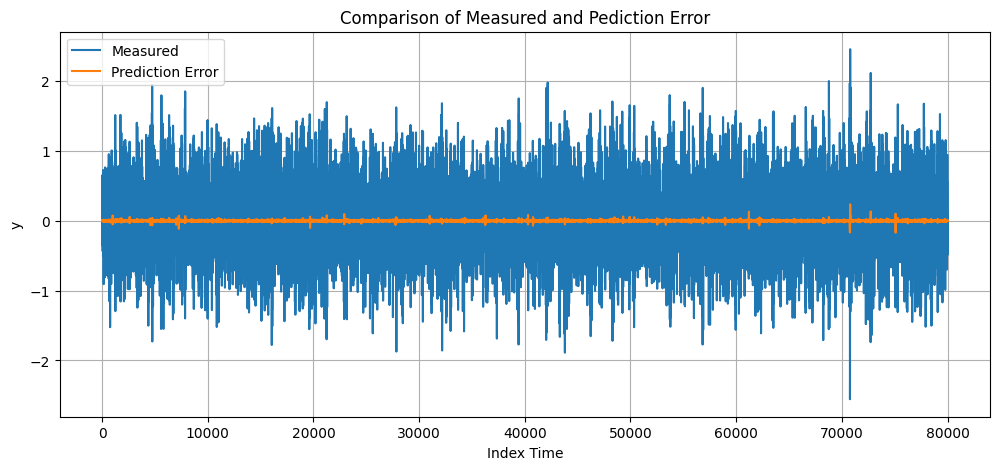

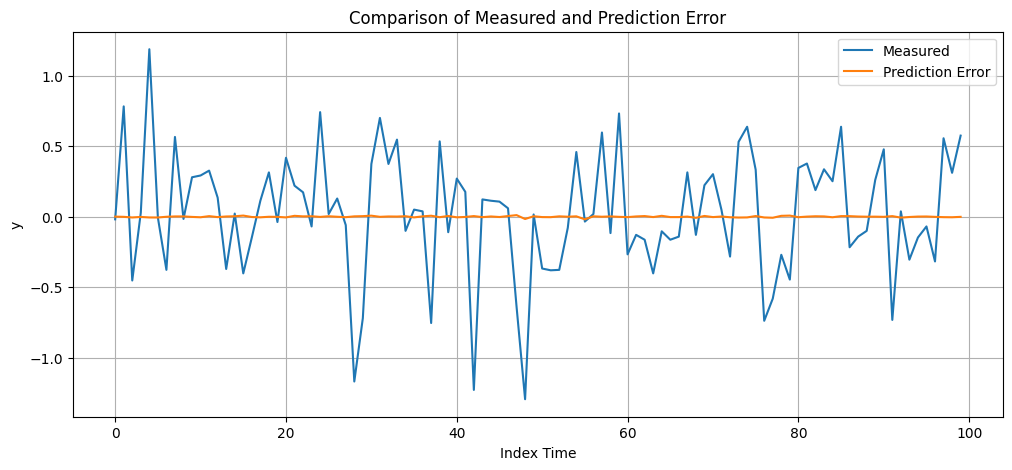

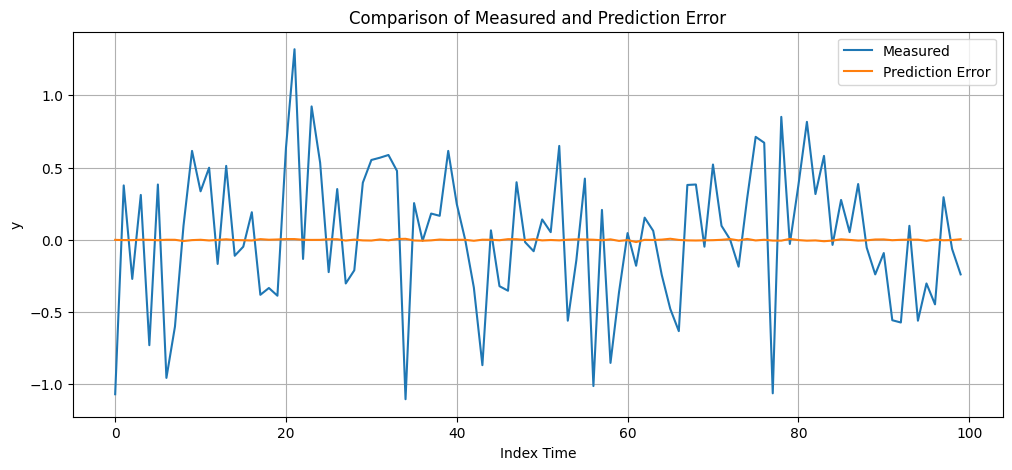

Xdata NRMS: 0.011096345224551015
Xval NRMS: 0.010521598263508444
Xtest NRMS: 0.008330382819826234


In [166]:
# Model Prediction

np.random.seed(43)

# Plot Measured vs Prediction error based on Xdata
ytest_pred = reg.predict(Xdata)

plt.figure(figsize=(12,5))
plt.plot(Ydata) 
plt.plot(Ydata - ytest_pred) 
plt.grid()
plt.title('Comparison of Measured and Pediction Error')
plt.xlabel('Index Time')
plt.ylabel('y')
plt.legend(['Measured', 'Prediction Error'])
plt.show()


#Plot Measured vs Prediction error based on Xval
ytest_pred_2 = reg.predict(Xval)

plt.figure(figsize=(12,5))
plt.plot(Yval) 
plt.plot(Yval - ytest_pred_2)
plt.grid()
plt.title('Comparison of Measured and Prediction Error')
plt.xlabel('Index Time')
plt.ylabel('y')
plt.legend(['Measured', 'Prediction Error'])
plt.show()


# Plot Measured vs Prediction error based on Xtest
ytest_pred_3 = reg.predict(Xtest)

plt.figure(figsize=(12,5))
plt.plot(Ytest) 
plt.plot(Ytest - ytest_pred_3)
plt.grid()
plt.title('Comparison of Measured and Prediction Error')
plt.xlabel('Index Time')
plt.ylabel('y')
plt.legend(['Measured', 'Prediction Error'])
plt.show()


# Test NRMS
test_nrms = np.mean((Ydata - ytest_pred) ** 2) ** 0.5 / np.std(Ydata)
print('Xdata NRMS:', test_nrms)

test_nrms_2 = np.mean((Yval - ytest_pred_2) ** 2) ** 0.5 / np.std(Yval)
print('Xval NRMS:', test_nrms_2)

test_nrms_3 = np.mean((Ytest - ytest_pred_3) ** 2) ** 0.5 / np.std(Ytest)
print('Xtest NRMS:', test_nrms_3)




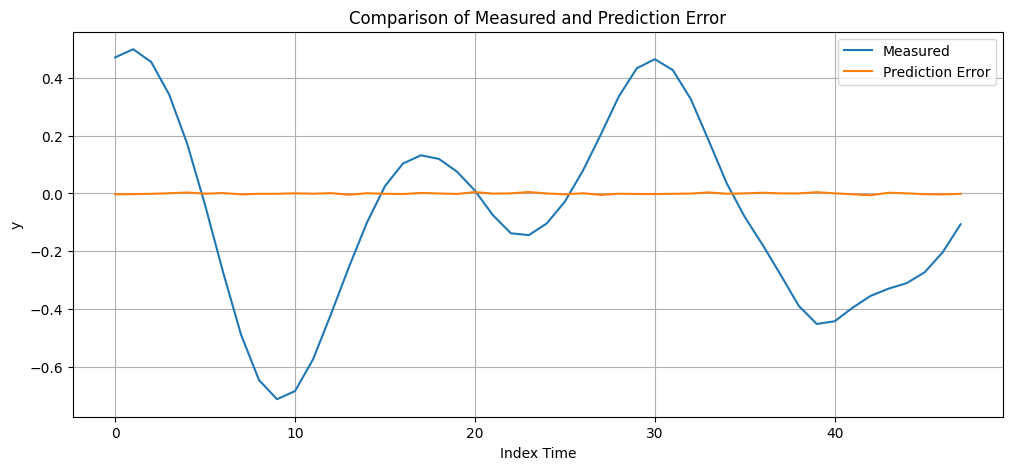

Xtest NRMS: 0.007562710451076602


In [167]:
#Prediction of simulation file 

# Load simulation data using csv
file_path = r'C:\Users\ongji\OneDrive\Documents\TUe\Quartile 4\5SC28\Design Assignment\gym-unbalanced-disk-master\disc-benchmark-files\test-simulation-submission-file.csv'
df = pd.read_csv(file_path)
XdataOut1 = df["# u"].to_numpy()
YdataOut1 = df[" th"].to_numpy()

# Predict using our model on the first 50 simulation data
Xdata1, Ydata1 = make_training_data(XdataOut1[:50], YdataOut1[:50], na=na, nb=nb)
ytest_pred_simulation_file = reg.predict(Xdata1) 

# Plot Measured vs Prediction error based on first 50 simulation data
plt.figure(figsize=(12,5))
plt.plot(Ydata1) 
plt.plot(Ydata1 - ytest_pred_simulation_file) # prediction error or residual error of the model
plt.grid()
plt.title('Comparison of Measured and Prediction Error')
plt.xlabel('Index Time')
plt.ylabel('y')
plt.legend(['Measured', 'Prediction Error'])
plt.show()


# Test NRMS for first 50 simulation data
test_nrms_simulation_file = np.mean((Ydata1 - ytest_pred_simulation_file) ** 2) ** 0.5 / np.std(Ydata1)
print('Xtest NRMS:', test_nrms_simulation_file)



# Determine the output for the rest of the data using the sequence/loop method



